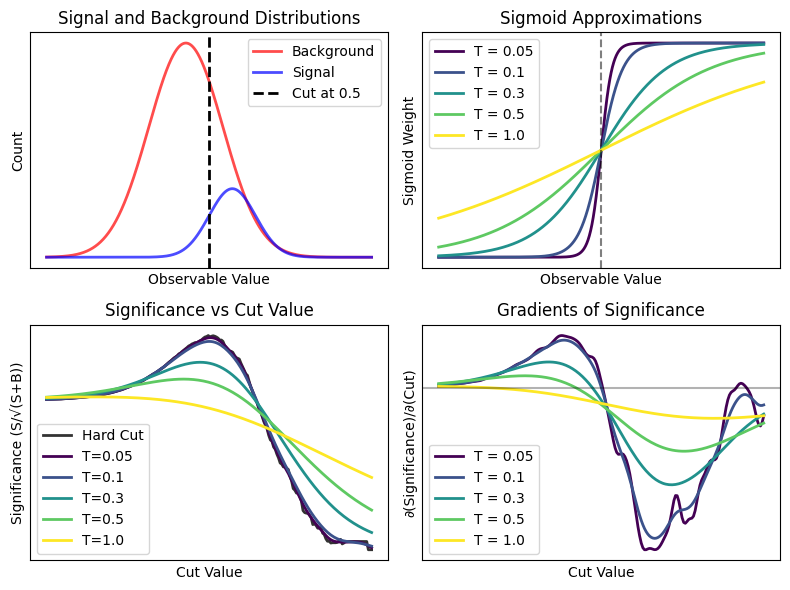

Optimal cut values:
Hard cut: 0.487
Sigmoid T=0.05: 0.513
Sigmoid T=0.1: 0.513
Sigmoid T=0.3: 0.362
Sigmoid T=0.5: 0.111
Sigmoid T=1.0: -1.271

Maximum significance:
Hard cut: 18.445
Sigmoid T=0.05: 18.261
Sigmoid T=0.1: 17.937
Sigmoid T=0.3: 16.143
Sigmoid T=0.5: 14.693
Sigmoid T=1.0: 13.162


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_signal = 1000
n_background = 5000

# Signal: Gaussian with mean=1, std=0.5
signal = np.random.normal(1.0, 0.5, n_signal)

# Background: Gaussian with mean=0, std=0.8
background = np.random.normal(0.0, 0.8, n_background)

# Define sigmoid function for smooth cut approximation
def sigmoid(x, a, T=1.0):
    """Sigmoid function: smooth approximation to step function
    T controls temperature (smoothness): lower T = sharper transition
    """
    return 1 / (1 + np.exp(-(x - a) / T))

# Define significance calculation
def calculate_significance(signal_data, background_data, cut_value, T=None):
    """Calculate significance S/sqrt(S+B) with optional sigmoid weighting"""
    if T is None:  # Hard cut
        s = np.sum(signal_data > cut_value)
        b = np.sum(background_data > cut_value)
    else:  # Smooth cut with sigmoid
        s = np.sum(sigmoid(signal_data, cut_value, T))
        b = np.sum(sigmoid(background_data, cut_value, T))
    
    # Avoid division by zero
    if s + b < 1e-6:
        return 0
    return s / np.sqrt(s + b)

# Define gradient calculation (numerical)
def calculate_gradient(signal_data, background_data, cut_value, T, eps=1e-6):
    """Numerical gradient of significance w.r.t. cut value"""
    sig_plus = calculate_significance(signal_data, background_data, cut_value + eps, T)
    sig_minus = calculate_significance(signal_data, background_data, cut_value - eps, T)
    return (sig_plus - sig_minus) / (2 * eps)

# Set up cut values for analysis
cut_values = np.linspace(-2, 3, 200)

# Temperature values for sigmoid approximation
# temperatures = [0.01, 0.1, 0.3, 1.0]  # Lower = sharper
# temperatures = [0.05, 0.1, 0.3, 1.0]  # Lower = sharper
temperatures = [0.05, 0.1, 0.3, 0.5, 1.0]  # Lower = sharper

# Create the four plots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot 1: Signal and Background distributions with cut line
ax1 = axes[0, 0]
x_range = np.linspace(-3, 4, 1000)
ax1.plot(x_range, norm.pdf(x_range, 0, 0.8) * n_background, 
         label='Background', color='red', alpha=0.7, linewidth=2)
ax1.plot(x_range, norm.pdf(x_range, 1, 0.5) * n_signal, 
         label='Signal', color='blue', alpha=0.7, linewidth=2)
optimal_cut = 0.5  # Approximate optimal cut for visualization
ax1.axvline(optimal_cut, color='black', linestyle='--', linewidth=2, 
            label=f'Cut at {optimal_cut}')
ax1.set_xlabel('Observable Value')
ax1.set_ylabel('Count')
ax1.set_title('Signal and Background Distributions')
ax1.legend()
# remove axis ticks
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.grid(True, alpha=0.3)

# Plot 2: Sigmoid functions for different temperatures
ax2 = axes[0, 1]
x_sigmoid = np.linspace(-1, 2, 1000)
colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))
for i, T in enumerate(temperatures):
    ax2.plot(x_sigmoid, sigmoid(x_sigmoid, optimal_cut, T), 
             label=f'T = {T}', color=colors[i], linewidth=2)
ax2.axvline(optimal_cut, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Observable Value')
ax2.set_ylabel('Sigmoid Weight')
ax2.set_title('Sigmoid Approximations')
ax2.legend()
ax2.set_xticks([])
ax2.set_yticks([])

# ax2.grid(True, alpha=0.3)

# Plot 3: Significance vs Cut Value
ax3 = axes[1, 0]

# Calculate significance for hard cut
significance_hard = []
for cut in cut_values:
    sig = calculate_significance(signal, background, cut)
    significance_hard.append(sig)

# Calculate significance for different temperatures
significance_smooth = {}
for T in temperatures:
    sig_list = []
    for cut in cut_values:
        sig = calculate_significance(signal, background, cut, T)
        sig_list.append(sig)
    significance_smooth[T] = sig_list

# Plot hard cut
ax3.plot(cut_values, significance_hard, 'k-', linewidth=2, 
         label='Hard Cut', alpha=0.8)

# Plot smooth cuts
for i, T in enumerate(temperatures):
    ax3.plot(cut_values, significance_smooth[T], 
             color=colors[i], linewidth=2, label=f'T={T}')

ax3.set_xlabel('Cut Value')
ax3.set_ylabel('Significance (S/√(S+B))')
ax3.set_title('Significance vs Cut Value')
ax3.legend()
ax3.set_xticks([])
ax3.set_yticks([])

# ax3.grid(True, alpha=0.3)

# Plot 4: Gradients
ax4 = axes[1, 1]

# Calculate gradients for different temperatures
for i, T in enumerate(temperatures):
    gradients = []
    for cut in cut_values:
        grad = calculate_gradient(signal, background, cut, T)
        gradients.append(grad)
    ax4.plot(cut_values, gradients, color=colors[i], 
             linewidth=2, label=f'T = {T}')

ax4.set_xlabel('Cut Value')
ax4.set_ylabel('∂(Significance)/∂(Cut)')
ax4.set_title('Gradients of Significance')
ax4.legend()
# ax4.grid(True, alpha=0.3)
ax4.axhline(0, color='black', linestyle='-', alpha=0.3)
ax4.set_xticks([])
ax4.set_yticks([])


plt.tight_layout()
plt.show()

# Print optimal cut values for comparison
print("Optimal cut values:")
print(f"Hard cut: {cut_values[np.argmax(significance_hard)]:.3f}")
for T in temperatures:
    optimal_idx = np.argmax(significance_smooth[T])
    print(f"Sigmoid T={T}: {cut_values[optimal_idx]:.3f}")

# Demonstrate the key insight
print(f"\nMaximum significance:")
print(f"Hard cut: {max(significance_hard):.3f}")
for T in temperatures:
    print(f"Sigmoid T={T}: {max(significance_smooth[T]):.3f}")

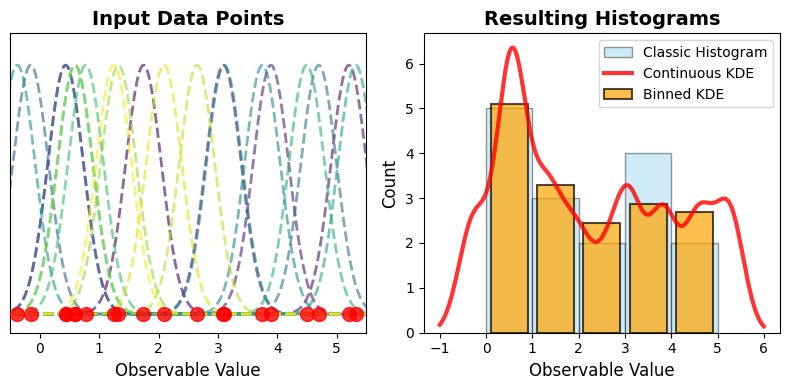

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Create a small dataset for demonstration
np.random.seed(42)
data_points = np.random.uniform(-0.5, 5.5, 20)  # Random data points
# data_points = np.array([1.2, 1.5, 2.8, 3.1, 4.5, 5.9, 6.2, 6.9, 7.8, 8.1, 8.9])
n_points = len(data_points)

# Parameters
x_range = np.linspace(-1, 6, 700)
bandwidth = 0.3 # KDE bandwidth
n_bins = 5
bin_edges = np.linspace(0, 5, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def gaussian_kde(x, data, bandwidth):
    """Compute KDE using Gaussian kernels"""
    kde = np.zeros_like(x)
    for point in data:
        kde += norm.pdf(x, point, bandwidth)
    return kde / len(data)

def binned_kde(data, bin_edges, bandwidth):
    """Compute binned KDE - sum of Gaussian contributions in each bin"""
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]
    binned_values = np.zeros(len(bin_centers))
    
    for i, center in enumerate(bin_centers):
        # Sum contributions from all data points to this bin
        for point in data:
            # Integral of Gaussian over the bin interval
            left_edge = bin_edges[i]
            right_edge = bin_edges[i + 1]
            contribution = (norm.cdf(right_edge, point, bandwidth) - 
                          norm.cdf(left_edge, point, bandwidth))
            binned_values[i] += contribution
    
    return binned_values

# Create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# 1. Data points visualization
ax1.scatter(data_points, np.zeros_like(data_points), s=100, c='red', zorder=3, alpha=0.8)
ax1.set_xlim(-0.5, 5.5)
ax1.set_ylim(-0.1, 1.5)
ax1.set_xlabel('Observable Value', fontsize=12)
ax1.set_title('Input Data Points', fontsize=14, fontweight='bold')
ax1.set_yticks([])

# 3. Individual Gaussian kernels + overlay
colors = plt.cm.viridis(np.linspace(0, 1, len(data_points)))

# Plot individual Gaussians
for i, point in enumerate(data_points):
    gaussian = norm.pdf(x_range, point, bandwidth)
    ax1.plot(x_range, gaussian, '--', alpha=0.6, color=colors[i], linewidth=2,
             label=f'Point {point:.1f}')

# Compute binned KDE
binned_values = binned_kde(data_points, bin_edges, bandwidth)

# Plot classic histogram for comparison
ax2.hist(data_points, bins=bin_edges, alpha=0.4, color='skyblue', 
         edgecolor='black', linewidth=1, label='Classic Histogram')

# Plot binned KDE as bars
bar_width = bin_edges[1] - bin_edges[0]
ax2.bar(bin_centers, binned_values, width=bar_width * 0.8, 
        alpha=0.7, color='orange', edgecolor='black', linewidth=1.5,
        label='Binned KDE')

# Overlay continuous KDE for reference
kde_for_overlay = gaussian_kde(x_range, data_points, bandwidth)
ax2.plot(x_range, kde_for_overlay * len(data_points), 'red', linewidth=3, 
         label='Continuous KDE', alpha=0.8)

ax2.legend(fontsize=10)

ax2.set_xlabel('Observable Value', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Resulting Histograms', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
